In [44]:
# generating Minimum Snap trajectories as a benchmark for the G&CNets
import matplotlib.pyplot as plt
import numpy as np
from sympy import *

# RACE TRACK
# waypoint: [x, y, z, yaw]
waypoints = np.array([
    [-8, -2, -1.5, 0.],         # start (hover)
]+[
    [-5, -2, -1.5, 0.],         # gate 1
    [ 5, -2, -1.5, 0.],         # gate 2
    [ 5,  2, -1.5, np.pi],      # gate 3
    [-5,  2, -1.5, np.pi],      # gate 4
]*4+[
    [-8, -2, -1.5, np.pi]       # end (hover)
])

region = np.array([
    [-20, 20],  # xmin, xmax
    [-20, 20],  # ymin, ymax
    [-20, 0]   # zmin, zmax
])
    

# Position and yaw are described by nth order polynomials
t = Symbol('t')

# Degree of polynomials
n=6

# number of trajectories
n_traj = len(waypoints)-1

parameters = [Matrix([['p'+str(i)+str(j)+str(k) for j in range(n+1)] for k in range(4)]) for i in range(n_traj)]
T = [Symbol('T'+str(i)) for i in range(n_traj)]

def get_traj(idx):
    P = parameters[idx]
    x   = sum([P[0,i]*t**i for i in range(n+1)])
    y   = sum([P[1,i]*t**i for i in range(n+1)])
    z   = sum([P[2,i]*t**i for i in range(n+1)])
    psi = sum([P[3,i]*t**i for i in range(n+1)])
    return x,y,z,psi

In [45]:
# Objective function
kr = 4
kpsi = 2

# pos and yaw have equal weight
mur = 1
mupsi = 1

def get_Obj(idx):
    x,y,z,psi = get_traj(idx)
    return integrate(mur*(diff(x,t,kr)**2+diff(y,t,kr)**2+diff(z,t,kr)**2) + mupsi*(diff(psi,t,kpsi)**2), (t, 0, T[idx]))

Obj = sum(get_Obj(i) for i in range(n_traj))

In [46]:
# Get constraints of the ith trajectory
def get_constraints(idx):
    x,y,z,psi = get_traj(idx)
    
    # Equality constraints g(p) = 0
    g=[]
    
    # START POINT CONSTRAINTS
    if idx==0:
        # Initial state 
        g.append(x.subs(t,0)-waypoints[0][0])
        g.append(y.subs(t,0)-waypoints[0][1])
        g.append(z.subs(t,0)-waypoints[0][2])
        g.append(psi.subs(t,0)-waypoints[0][3])
        # (hover)
        for i in range(1, 3):
            g.append(diff(x,t,i).subs(t,0))
            g.append(diff(y,t,i).subs(t,0))
            g.append(diff(z,t,i).subs(t,0))
            g.append(diff(psi,t,i).subs(t,0))
    else:
        # Enforce continuity of the first kr derivatives of rT and first kψ derivatives of ψT
        x_,y_,z_,psi_ = get_traj(idx-1)
        for i in range(kr+1):
            g.append(diff(x_,t,i).subs(t,T[idx-1])-diff(x,t,i).subs(t,0))
            g.append(diff(y_,t,i).subs(t,T[idx-1])-diff(y,t,i).subs(t,0))
            g.append(diff(z_,t,i).subs(t,T[idx-1])-diff(z,t,i).subs(t,0))
        for i in range(kpsi+1):
            g.append(diff(psi_,t,i).subs(t,T[idx-1])-diff(psi,t,i).subs(t,0))
    
    # END POINT CONSTRAINTS
    g.append(x.subs(t,T[idx])-waypoints[idx+1][0])
    g.append(y.subs(t,T[idx])-waypoints[idx+1][1])
    g.append(z.subs(t,T[idx])-waypoints[idx+1][2])
    g.append(psi.subs(t,T[idx])-waypoints[idx+1][3])

    if idx == n_traj-1:
        # end point hover
        for i in range(1, 3):
            g.append(diff(x,t,i).subs(t,T[idx]))
            g.append(diff(y,t,i).subs(t,T[idx]))
            g.append(diff(z,t,i).subs(t,T[idx]))
            g.append(diff(psi,t,i).subs(t,T[idx]))
    else:
        # velocity must align with yaw
        psi = waypoints[idx+1][3]
        g.append(sin(psi)*diff(x,t).subs(t,T[idx])-cos(psi)*diff(y,t).subs(t,T[idx]))
        g.append(diff(z,t).subs(t,T[idx]))
        
    # Region constraints
    # add constraints to keep the trajectory within the region
    return g

In [47]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval('option solver snopt;')

ampl.eval('param Tn default '+ str(n_traj) + ';')

# VARIABLES
for t_ in T:
    ampl.eval('var ' + str(t_) + ', >= 0;')
for P in parameters:
    for p in P:
        ampl.eval('var ' + str(p) + ';')

# OBJECTIVE
objective = str(Obj)
objective = objective.replace('**','^')
ampl.eval('minimize myobjective: '+str(objective) +';')

# CONSTRAINTS
ampl.eval('subject to time_constraint: '+str(sum(T))+'=Tn;')

for idx in range(n_traj):
    ampl.eval('subject to time_constraint' + str(idx) + ':' + str(T[idx]) + '= 1.;')

# ADD CONSTRAINTS FOR EACH TRAJ
for idx in range(n_traj):
    g = get_constraints(idx)
    for i in range(len(g)):
        constraint = str(g[i])
        constraint = constraint.replace('**','^')
        ampl.eval('subject to constraint' + str(idx) + '_' + str(i) + ':' + str(constraint) + '=0;')

# SOLVE
ampl.solve()
    
# REMOVE TIME CONSTRIANTS
for idx in range(n_traj):
    ampl.getConstraint('time_constraint'+str(idx)).drop()

# SOLVE
ampl.solve()

SNOPT 7.2-4 SNOPT 7.2-4 : Optimal solution found.
359 iterations, objective 1548361.252
SNOPT 7.2-4 SNOPT 7.2-4 : Optimal solution found.
356 iterations, objective 350375.1494
Nonlin evals: obj = 217, grad = 216, constrs = 217, Jac = 216.


In [48]:
# SOLVE AGAIN?
ampl.solve()

SNOPT 7.2-4 SNOPT 7.2-4 : Optimal solution found.
184 iterations, objective 350375.1495
Nonlin evals: obj = 3, grad = 2, constrs = 3, Jac = 2.


In [49]:
def get_traj_solved(idx):
    x,y,z,psi = get_traj(idx)
    x   = x.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    y   = y.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    z   = z.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    psi = psi.subs([(str(p), ampl.getVariable(str(p)).value()) for p in parameters[idx]])
    return x,y,z,psi

In [50]:
x,y,z,psi =[],[],[],[]
T_ = np.cumsum([0] + [ampl.getVariable(str(T[i])).value() for i in range(n_traj)])
for i in range(n_traj):
    xi,yi,zi,psii = get_traj_solved(i)
    x.append((xi.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))
    y.append((yi.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))
    z.append((zi.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))
    psi.append((psii.subs(t,t-T_[i]),(t>=T_[i])&(t<T_[i+1])))

x.append((waypoints[-1][0], True))
y.append((waypoints[-1][1], True))
z.append((waypoints[-1][2], True))
psi.append((waypoints[-1][3], True))

x   = Piecewise(*x, evaluate=False)
y   = Piecewise(*y, evaluate=False)
z   = Piecewise(*z, evaluate=False)
psi = Piecewise(*psi, evaluate=False)
print(T_)

[ 0.          0.65619693  1.22387878  2.94780206  3.38465307  4.89934419
  5.35446817  6.9014878   7.35345883  8.89666961  9.34843211 10.89237235
 11.34417159 12.89063234 13.36337965 14.8419964  15.50809101 17.        ]


In [51]:
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(0,20)
cmap = cm.jet 

def color_plot(x_axis,y_axis,color_axis,step=1):
    for i in reversed(range(step,len(x_axis),step)):
        ax = plt.gca()
        ax.plot([x_axis[i-step], x_axis[i]],[y_axis[i-step], y_axis[i]], color=cmap(norm(color_axis[i])))
        ax.axis('equal')
        
def color_plot3D(x_axis,y_axis,z_axis,color_axis,step=1):
    ax = plt.axes(projection='3d')
    for i in reversed(range(step,len(x_axis),step)):
        ax.plot3D([x_axis[i-step], x_axis[i]],[y_axis[i-step], y_axis[i]],[z_axis[i-step], z_axis[i]], color=cmap(norm(color_axis[i])))
#         ax.axis('equal')

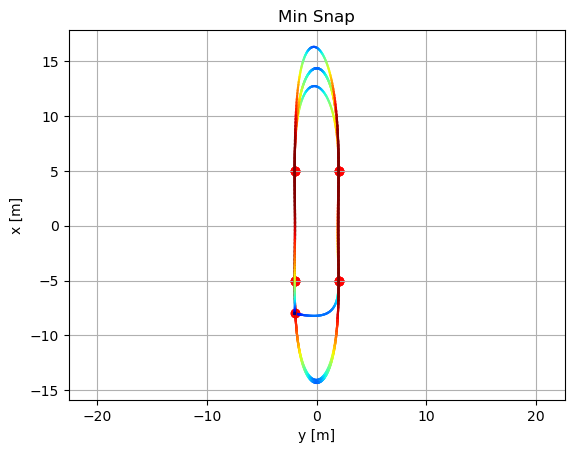

In [52]:
vx = diff(x,t)
vy = diff(y,t)
V = sqrt(vx**2+vy**2)

t_ = np.linspace(0,T_[-1],1000)
x_ = lambdify(t,x)
y_ = lambdify(t,y)
z_ = lambdify(t,z)
psi_ = lambdify(t,psi)
V_ = lambdify(t,V)

color_plot(y_(t_),x_(t_),V_(t_))
plt.scatter(waypoints[:,1],waypoints[:,0],color='red')
plt.xlabel('y [m]')
plt.ylabel('x [m]')
plt.grid()
plt.gca().axis('equal')
plt.title('Min Snap')
plt.show()

In [10]:
z=simplify(z)
psi=simplify(psi)

## Generate C code

In [11]:
from sympy.utilities.codegen import codegen

# TRANSFORM TO CYBERZOO COORDINATES
x_ = x #-2.
y_ = y #-1.5
z_ = z #-1.

angle = 0 #-33*np.pi/180
x_new = x_*cos(angle) - y_*sin(angle)
y_new = x_*sin(angle) + y_*cos(angle)
x_ = x_new
y_ = y_new
psi_ = psi + angle

# TIME SCALE PARAMETER
alpha = Symbol('alpha')
x_ = x_.subs(t,alpha*t)
y_ = y_.subs(t,alpha*t)
z_ = z_.subs(t,alpha*t)
psi_ = psi_.subs(t,alpha*t)

vx_ = diff(x_,t)
vy_ = diff(y_,t)
vz_ = diff(z_,t)

ax_ = diff(vx_,t)
ay_ = diff(vy_,t)
az_ = diff(vz_,t)

print('generating code')
[(c_name, c_code), (h_name, c_header)] = codegen([
    ("get_x", x_),
    ("get_y", y_),
    ("get_z", z_),
    ("get_psi", psi_),
    ("get_vx", vx_),
    ("get_vy", vy_),
    ("get_vz", vz_),
    ("get_ax", ax_),
    ("get_ay", ay_),
    ("get_az", az_)
], "C", "min_snap", header=True, empty=False)

generating code


In [12]:
c_header = c_header.replace('int', 'double')
c_header = c_header.replace('()', '(double alpha, double t)')
# print(c_header)

In [13]:
c_code = c_code.replace('int', 'double')
c_code = c_code.replace('()', '(double alpha, double t)')
# print(c_code)

In [14]:
text_file = open('c_code/'+c_name, "w")
n = text_file.write(c_code)
text_file.close()

text_file = open('c_code/'+h_name, "w")
n = text_file.write(c_header)
text_file.close()

## Test C code

In [15]:
import subprocess
import ctypes
import os

path = os.path.abspath('c_code')

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270

# Create object files
print('Create object files')
subprocess.call('gcc -fPIC -c *.c', shell=True, cwd=path)

# Create library
print('Create library')
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)

# Remove object files
subprocess.call('rm *.o', shell=True, cwd=path)

Create object files
Create library


0

In [16]:
lib_path = os.path.abspath("c_code/libtools.so")
fun = ctypes.CDLL(lib_path)

In [17]:
fun.get_x.argtypes = [ctypes.c_double, ctypes.c_double]
fun.get_x.restype = ctypes.c_double

fun.get_y.argtypes = [ctypes.c_double, ctypes.c_double]
fun.get_y.restype = ctypes.c_double

fun.get_z.argtypes = [ctypes.c_double, ctypes.c_double]
fun.get_z.restype = ctypes.c_double

In [18]:
x__ = [fun.get_x(1,ti) for ti in t_]
y__ = [fun.get_y(1,ti) for ti in t_]
z__ = [fun.get_z(1,ti) for ti in t_]

Using matplotlib backend: module://matplotlib_inline.backend_inline


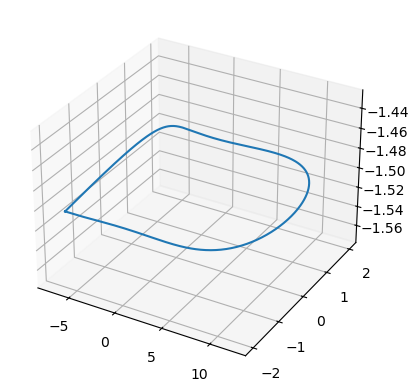

In [19]:
%matplotlib
ax = plt.axes(projection='3d')
ax.plot3D(x__,y__,z__)
plt.show()